In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
from keras.models import Model
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]


1 Physical GPUs, 1 Logical GPUs


2023-09-18 18:20:48.835404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21336 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [3]:
### PROCESSING .hdf files

#folder = "/uio/hume/student-u37/fslippe/data/training_data/MOD02QKM/normalized_data/"
folder = "/uio/hume/student-u37/fslippe/data/nird_mount/MOD02QKM_202012-202104/"

#folder = "/uio/hume/student-u37/fslippe/data/nird_mount/MOD02QKM_202012-202104/normalized_data/"

start = "20210321"
end = "20210321"
dates = ["20210321"]
dates_converted = []
for date in dates:
    dates_converted.append(convert_to_day_of_year(date))

start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
print(start_converted)
print(end_converted)
x = [xi for xi in  extract_250m_data(folder, bands=[1], date_list=dates_converted) if xi.shape[0] > 256]
#x = extract_250m_data(folder, bands=[1], start_date=start_converted, end_date=end_converted)
len(x)


2021080
2021080
Preprocess
Date: 20210321


100%|██████| 17/17 [00:04<00:00,  3.49it/s]


16

In [4]:
# ### PROCESSING .npz files

# #folder = "/uio/hume/student-u37/fslippe/data/training_data/MOD02QKM/normalized_data/"
# folder = "/uio/hume/student-u37/fslippe/data/nird_mount/MOD02QKM_202012-202104/normalized_data/"

# #folder = "/uio/hume/student-u37/fslippe/data/nird_mount/MOD02QKM_202012-202104/normalized_data/"

# all_files = [f for f in os.listdir(folder) if f.endswith('.npz')]

# def process_file(file):
#     print("file")
#     loaded = np.load(folder + file)
#     arrays_from_file = [loaded[key][:,:,0] for key in loaded]# if loaded[key].shape[0] >= 256]
#     return arrays_from_file

# # Use a process pool to process each file in parallel
# with ProcessPoolExecutor(max_workers = len(all_files)) as executor:
#     X_lists = list(executor.map(process_file, all_files))

# # Flatten the result
# X = [item for sublist in X_lists for item in sublist]


In [4]:
import autoencoder
import importlib
importlib.reload(autoencoder)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
bands = [1]
patch_size = 256

autoencoder = SimpleAutoencoder(len(bands), patch_size, patch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model = autoencoder.model(optimizer=optimizer, threshold=0.09,loss="combined")


Input should already be normalized. Call self.normalize to normalize list of data


In [5]:
normalized_data = autoencoder.normalize(x)
normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)

#model.fit(normalized_patches, normalized_patches, epochs=200, batch_size=32)


In [6]:
model.fit(normalized_patches, normalized_patches, epochs=100, batch_size=32)

Epoch 1/100


2023-09-18 18:22:01.097975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


240/240 [==============================] - 17s 45ms/step - loss: 0.0126
Epoch 2/100
240/240 [==============================] - 10s 42ms/step - loss: 0.0077
Epoch 3/100
211/240 [=========================>....] - ETA: 1s - loss: 0.0074

KeyboardInterrupt: 

In [8]:
model.save("/uio/hume/student-u37/fslippe/data/models/test_1day_autoencoder")
autoencoder.encoder.save("/uio/hume/student-u37/fslippe/data/models/test_1day_encoder")


2023-09-18 18:09:47.243008: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


KeyboardInterrupt: 

In [ ]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
bands = [1]
patch_size = 256
from tensorflow.keras.models import load_model
print(len(bands))
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

encoder = load_model("/uio/hume/student-u37/fslippe/data/models/test_1day_encoder")

1


In [ ]:
# normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data[:4]], axis=0)

start = 3
index_list = [3, 10, 11, 12, 13]
cluster_map = autoencoder_predict.kmeans([normalized_data[i] for i in index_list], n_clusters=10, encoder=encoder)


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


: 

: 

In [ ]:
index_list = [3, 7, 8, 9]
print(np.max(normalized_data[8][:,:,0]))
print(np.max(normalized_data[3][:,:,0]))
print(np.where(normalized_data[3][:,:,0] <0.8))


1.0
1.0
(array([   0,    0,    0, ..., 7319, 7319, 7319]), array([   0,    1,    2, ..., 5413, 5414, 5415]))


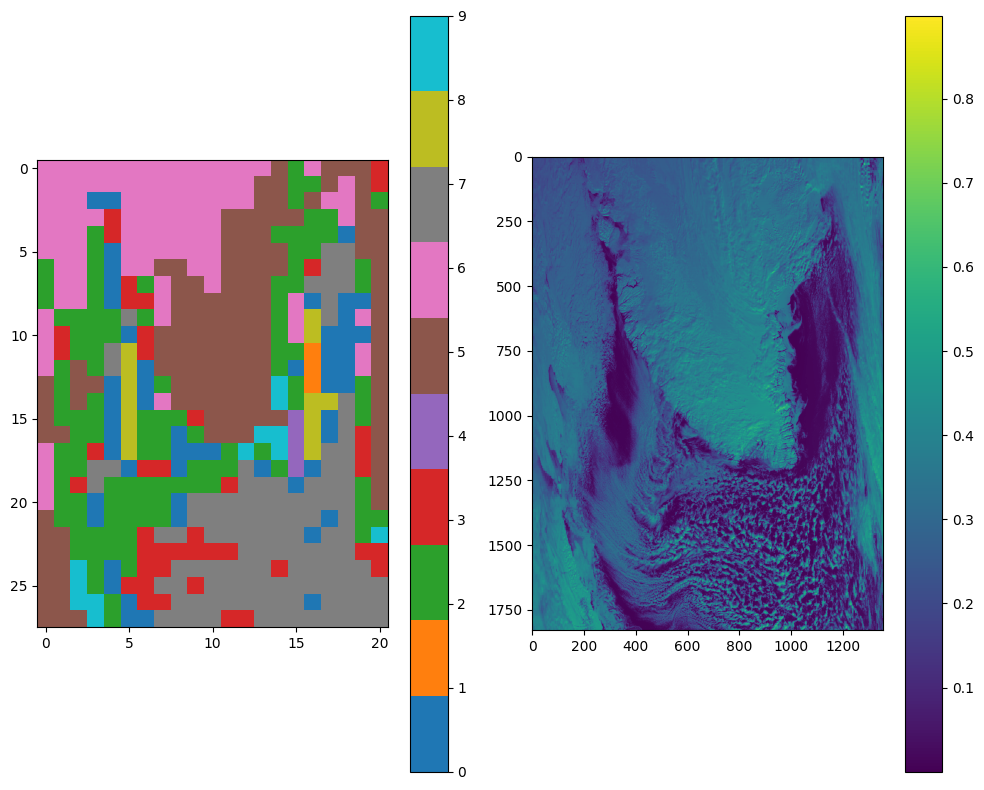

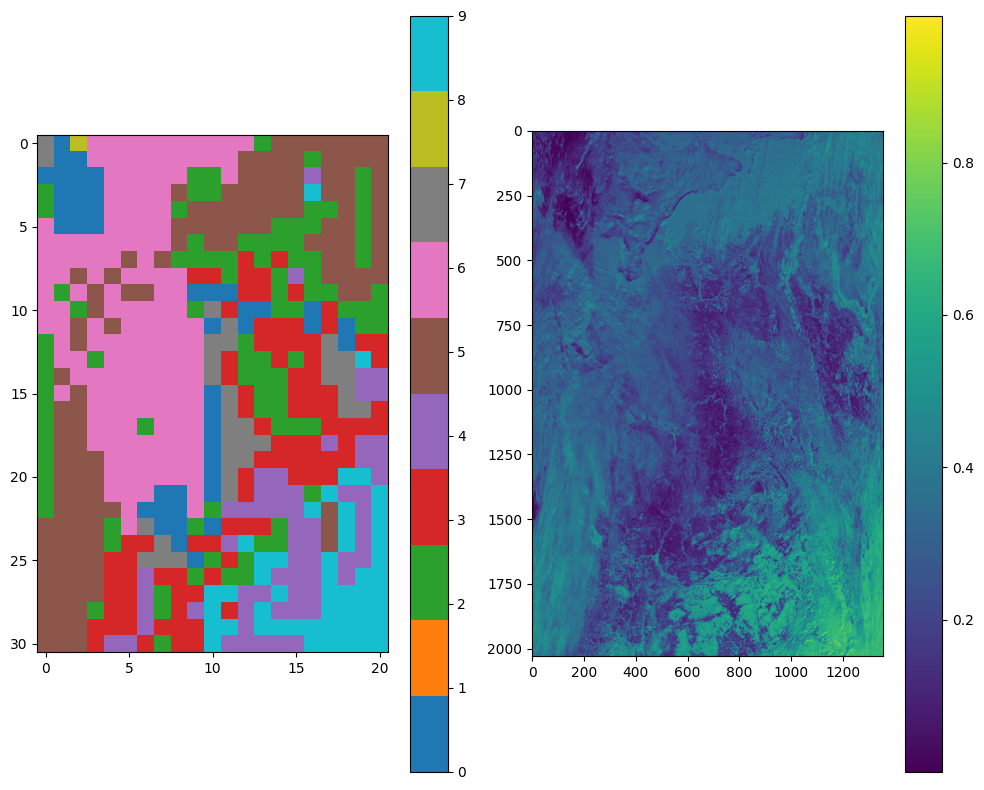

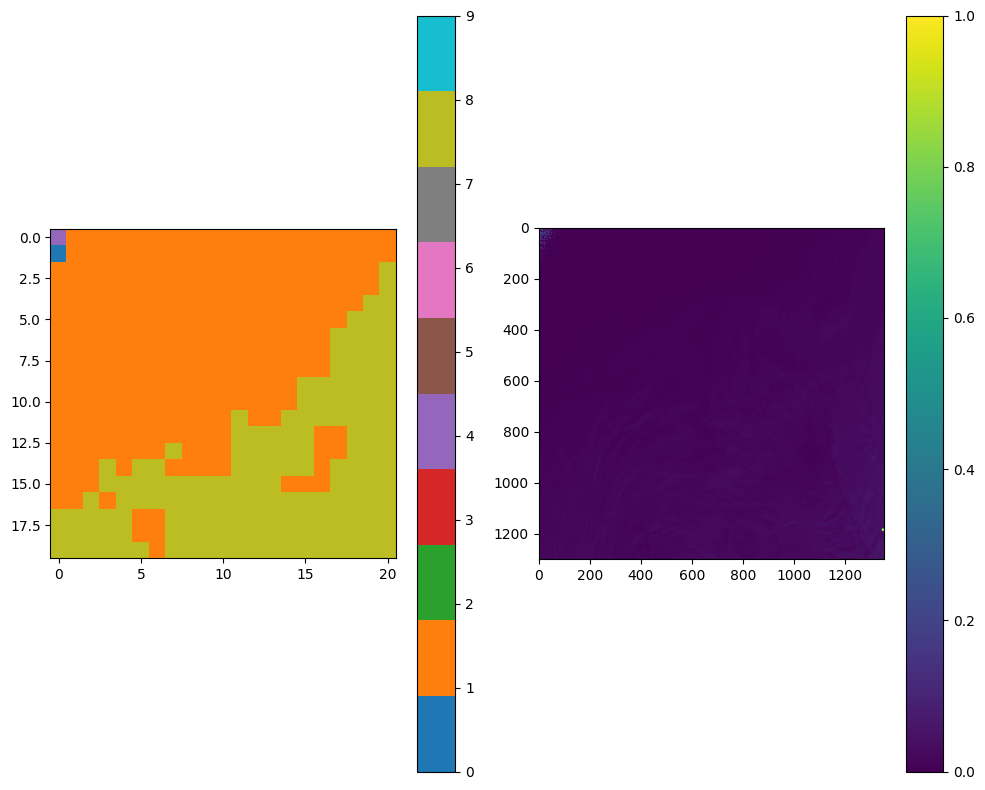

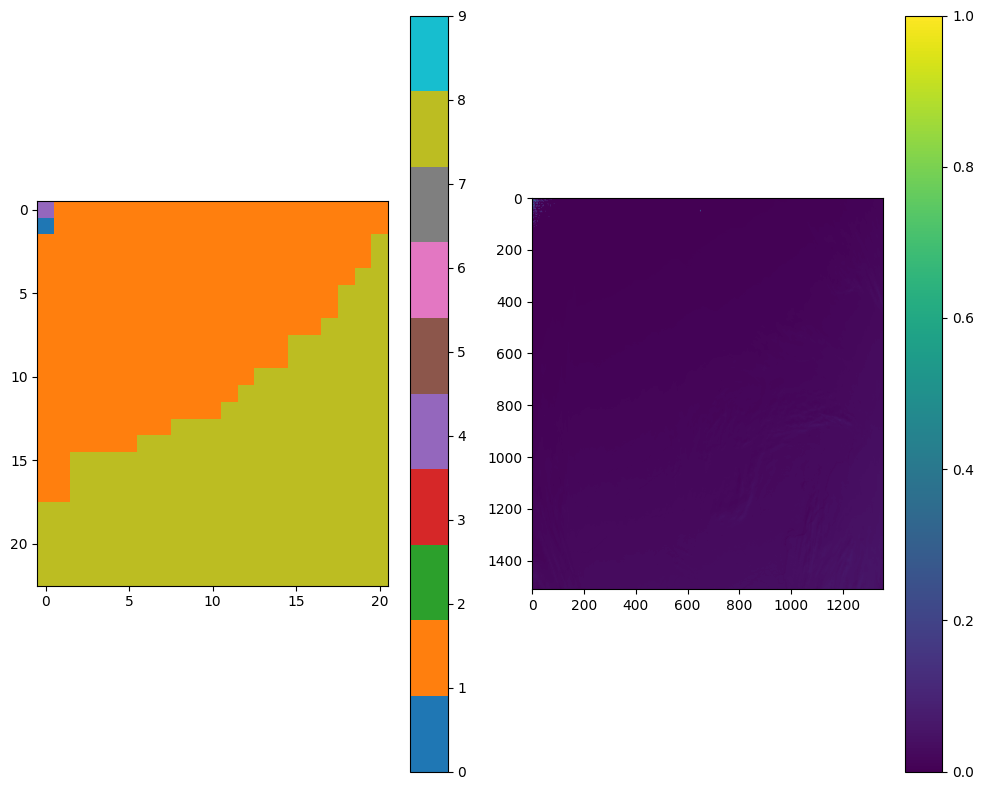

In [ ]:
from matplotlib.colors import Normalize

# Determine global min and max labels
global_min = np.min([np.min(cm) for cm in cluster_map])
global_max = np.max([np.max(cm) for cm in cluster_map])

norm = Normalize(vmin=global_min, vmax=global_max)

for i in range(len(cluster_map)):
    fig, axs = plt.subplots(1, 2, figsize=[10, 8])
    
    cb = axs[0].imshow(cluster_map[i], cmap="tab10", norm=norm)
    plt.colorbar(cb, ax=axs[0])
    
    cb = axs[1].imshow(normalized_data[index_list[i]][::4, ::4, 0])
    plt.colorbar(cb, ax=axs[1])

    plt.tight_layout()


In [ ]:
folder = "/uio/hume/student-u37/fslippe/data/cao/"
i=0
print(folder + all_files[i])
hdf = SD(folder + all_files[i], SDC.READ)
print(hdf.attributes())
lon = hdf.select('Longitude')[:]
lat = hdf.select('Latitude')[:]
downsample_factor_x = int(lon.shape[0] / cluster_map[i].shape[0])
downsample_factor_y = int(lon.shape[1] / cluster_map[i].shape[1])
cluster_shape = cluster_map[i].shape
lon_d = lon[::downsample_factor_x, ::downsample_factor_y][:cluster_shape[0], :cluster_shape[1]]
lat_d = lat[::downsample_factor_x, ::downsample_factor_y][:cluster_shape[0], :cluster_shape[1]]
data = hdf.select("EV_250_Aggr1km_RefSB")[:][0]
print(data.shape)
hdf.select("EV_250_Aggr1km_RefSB").attributes()
print(lon.shape)
cluster_map[i].shape
datasets = hdf.datasets()   
for idx, sds in enumerate(datasets.keys()):
    print(idx, sds)




In [ ]:
fix, axs= plt.subplots(1,2)
axs[0].imshow(cluster_map[i])
axs[1].imshow(X[i][:,:,0])


In [ ]:
projection = ccrs.NorthPolarStereo()
fig, axs = plt.subplots(1, 2, figsize=[10,5], subplot_kw={'projection': projection}, dpi=300)
cb = axs[0].pcolormesh(lon_d, lat_d, cluster_map[i], transform=ccrs.PlateCarree(), cmap="jet")  
axs[0].coastlines()
gl = axs[0].gridlines(draw_labels=True)
plt.colorbar(cb)

cb = axs[1].pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), vmin=0)  
axs[1].coastlines()
gl = axs[1].gridlines(draw_labels=True)
plt.colorbar(cb)
plt.show()

In [ ]:
# patches_predict = autoencoder.extract_patches(dataset_5.reshape((1,dataset_5.shape[0], dataset_5.shape[1], 1)))
# predict = autoencoder.autoencoder.predict(patches_predict)
# predict.shape

# #for i in range(83, 90, 2):
# pictures = 12
# patch_start = 68
# fig, axs = plt.subplots(2, pictures, figsize=[pictures*2,5])
# i=0
# for patch_number in range(patch_start, patch_start+pictures):
#     axs[0, i].imshow(patches_predict[patch_number], cmap="gray")
#     axs[1, i].imshow(predict[patch_number,:,:,0], cmap="gray")
    
#     # Turn off ticks and axis labels for both x and y
#     axs[0, i].set_yticks([])
#     axs[0, i].set_xticks([])
#     axs[0, i].axis('off')
    
#     axs[1, i].set_yticks([])
#     axs[1, i].set_xticks([])
#     axs[1, i].axis('off')
    
#     i += 1
# plt.tight_layout()

patches_predict = autoencoder2.extract_patches(dataset_5.reshape((1,dataset_5.shape[0], dataset_5.shape[1], 1)))
predict = autoencoder2.autoencoder.predict(patches_predict)
print(predict.shape)

#for i in range(83, 90, 2):
pictures = 10
patch_start = 320
fig, axs = plt.subplots(2, pictures, figsize=[pictures*2,5])
i=0
for patch_number in range(patch_start, patch_start+pictures):
    axs[0, i].imshow(patches_predict[patch_number], cmap="gray")
    axs[1, i].imshow(predict[patch_number,:,:,0], cmap="gray")
    
    # Turn off ticks and axis labels for both x and y
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[0, i].axis('off')
    
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].axis('off')
    
    i += 1
plt.tight_layout()

plt.figure()
plt.imshow(dataset_5, cmap='gray')

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmp = axes[0].imshow(dataset_2, cmap='gray')
plt.colorbar(cmp, ax=axes[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

cmp = axes[1].imshow(labels_img, cmap='tab10')
plt.colorbar(cmp, ax=axes[1])
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()

In [ ]:
encoder = Model(flattened_input, encoded)
encoded_imgs = encoder.predict(data)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Reduce the encoded images to 2D using PCA
pca = PCA(n_components=2)
encoded_imgs_2d = pca.fit_transform(encoded_imgs)

# Now cluster the 2D encoded images
n_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters)
cluster_assignments = kmeans.fit_predict(encoded_imgs_2d)

print(cluster_assignments.shape)

# If you want to visualize the clusters using matplotlib:
plt.scatter(encoded_imgs_2d[:, 0], encoded_imgs_2d[:, 1], c=cluster_assignments, cmap='jet')
plt.colorbar()
plt.title('Clusters in 2D')
plt.show()


In [ ]:
decoded_imgs = autoencoder.predict(dataset_2)
fig, axs = plt.subplots(1, 2, figsize=[10,5])

cmp = axs[0].imshow(dataset_2, cmap="gray")
plt.colorbar(cmp)
cmp = axs[1].imshow(decoded_imgs,cmap="gray")
plt.colorbar(cmp)

#decoded_imgs_2d = decoded_imgs.reshape((-1, *input_shape))
# plt.contourf(decoded_imgs_2d)
# plt.show(


In [ ]:
decoded_imgs_reshaped = decoded_imgs.reshape(-1, 1)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(decoded_imgs_reshaped)
labels = kmeans.labels_
labels_reshaped = labels.reshape(2040, 1354)

# Assuming `original_img` is your original image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmp = axes[0].imshow(dataset_2, cmap='gray')  # or just cmap depending on the nature of your image
plt.colorbar(cmp)
axes[0].set_title('Original Image')
axes[0].axis('off')

cmp = axes[1].imshow(labels_reshaped, cmap='tab10')  # 'tab10' is a colormap with distinct colors
plt.colorbar(cmp)
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()


In [ ]:

# Parameters
block_size = (10, 10)  # Change accordingly
n_clusters = 5

# Divide the image into blocks and calculate the mean for each block
blocks = []
for i in range(0, decoded_imgs.shape[0], block_size[0]):
    for j in range(0, decoded_imgs.shape[1], block_size[1]):
        block = decoded_imgs[i:i+block_size[0], j:j+block_size[1]]
        block_mean = np.mean(block)
        blocks.append(block_mean)

blocks = np.array(blocks).reshape(-1, 1)

# Cluster the blocks
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(blocks)
labels = kmeans.labels_

# Construct the clustered image
clustered_img = np.zeros_like(decoded_imgs)
label_idx = 0
for i in range(0, decoded_imgs.shape[0], block_size[0]):
    for j in range(0, decoded_imgs.shape[1], block_size[1]):
        clustered_img[i:i+block_size[0], j:j+block_size[1]] = labels[label_idx]
        label_idx += 1

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Assuming `original_img` is your original image
axes[0].imshow(dataset_2, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(clustered_img, cmap='tab10')  # 'tab10' for distinct colors
axes[1].set_title('Clustered Image')
axes[1].axis('off')

plt.show()